## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.tag.perceptron import PerceptronTagger
from nltk.stem import PorterStemmer, WordNetLemmatizer
import time
from nltk.corpus import wordnet
import string

## Train Data Preprocessing

In [2]:
# import training data
data = pd.read_csv('./train_data_labels.csv')
data.head(6)

,train_id,abstract,label
0,1,As a new kind of two-dimensional carbon allotr...,Composites
1,2,"A.S.T.M. Standards, 1949. 6 volumes. Over 8,00...",Vinyl
2,3,Single-photon photoionization mass spectrometr...,Particulate matter
3,4,The molecular and crystal structure of the hyd...,Crystal structure
4,5,"The first [2]silacobaltocenophane, [(MeSi)(η-C...",Crystal structure
5,6,The development of a thermal sintering method ...,Composites


In [3]:
# check if there is any null value
print(data.isna().sum().to_string())

train_id    0
abstract    0
label       0


count       19.000000
mean      4736.842105
std       4438.147177
min        502.000000
25%       2505.500000
50%       4470.000000
75%       4501.500000
max      21476.000000


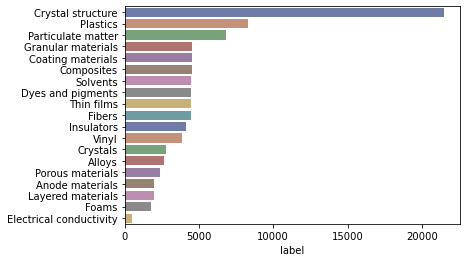

In [32]:
# visualize class labels
label_count = data.label.value_counts()
print(label_count.describe().to_string())
sns.barplot(y=label_count.index, x=label_count, palette='dark', alpha=.6);

In [6]:
# check for duplicated abstract
dup = data[data.duplicated('abstract', keep=False)] # show all duplicated results
print(dup.shape)
dup.head(6)

(9600, 3)


,train_id,abstract,label
24,25,Metal-free nitrogen-doped carbon materials are...,Fibers
34,35,"Here, we developed high-efficiency (>99.5%) po...",Fibers
41,42,"In this work, a single electrospun polymer nan...",Fibers
54,55,Developing lightweight and highly efficient el...,Composites
58,59,The metastable β polymorph of glycine exhibits...,Crystals
61,62,Bulk graphene (reduced graphene oxide)-reinfor...,Granular materials


In [7]:
# check if the duplicate abstracts have different labels
dup_lab_count = dup.groupby('abstract')['label'].apply(set).apply(len)
dup_abs = dup_lab_count[dup_lab_count.values>1].index

In [8]:
# return the index if the same abstracts have different labels
dup_index = [dup[dup.abstract==dup_abs[i]].index for i in range(len(dup_abs))]
dup_index = list(itertools.chain.from_iterable(dup_index))

In [9]:
# remove the wrong labeled abstracts
clean_data = data.copy()
clean_data.drop(dup_index, axis=0, inplace=True)
print(clean_data.shape)

(80448, 3)


In [10]:
# define stopwords containing English, German and French
en = stopwords.words('english')
ge = stopwords.words('german')
fr = stopwords.words('french')
stopword = en + ge + fr

In [11]:
# define function for text preprocessing
def get_clean(text):
      
    text = text.lower() # return lowercase
    text = re.sub('[.]', '', text) # replace '.' by space
    text = re.sub('[/(){}\[\]\|@,;∼~`!^$%&*#+_-]', ' ', text) # replace the specified symbols by space
    text = re.sub(r'[^0-9a-z #+_]', ' ', text) # replace all other symbols by space
    text = re.sub(r'[0123456789]', ' ', text) # replace number by space
    text = re.sub(r"\b[a-zA-Z]\b", '', text) # remove single letter
    # remove stopwords and return the cleaned text
    return ' '.join(word for word in text.split() if word not in stopword)

In [12]:
# create new column to store cleaned abstract
clean_data['clean'] = clean_data.abstract.apply(get_clean)
print(clean_data.clean[0])

new kind two dimensional carbon allotrope graphdiyne gdy consists sp sp hybridized carbon atoms recently used developing highly efficient photocatalytic systems unique properties study find gdy form pickering emulsion silver phosphate agpo nanoparticles exhibits largely enhanced photocatalytic activity visible light region system agpo acts photocatalytically active semiconductor gdy hydrophobic nanostructure photocatalytic activity agpo gdy based pickering emulsion toward photodegradation methylene blue mb photooxidation water investigated visible light irradiation compared previous agpo cnt agpo graphene based pickering emulsions agpo gdy based emulsion efficiently catalyzes mb degradation higher apparent rate constant min water oxidation photocatalytic activity improved times respectively enhancement photocatalytic activity mainly ascribed capability gdy acting acceptor photogenerated electrons agpo nanoparticles facilitating hole transportation well reducing ag ag study demonstrates

In [13]:
# create new column to store tokens
clean_data['tokens'] = clean_data['clean'].apply(word_tokenize)
print(clean_data.tokens[0])

['new', 'kind', 'two', 'dimensional', 'carbon', 'allotrope', 'graphdiyne', 'gdy', 'consists', 'sp', 'sp', 'hybridized', 'carbon', 'atoms', 'recently', 'used', 'developing', 'highly', 'efficient', 'photocatalytic', 'systems', 'unique', 'properties', 'study', 'find', 'gdy', 'form', 'pickering', 'emulsion', 'silver', 'phosphate', 'agpo', 'nanoparticles', 'exhibits', 'largely', 'enhanced', 'photocatalytic', 'activity', 'visible', 'light', 'region', 'system', 'agpo', 'acts', 'photocatalytically', 'active', 'semiconductor', 'gdy', 'hydrophobic', 'nanostructure', 'photocatalytic', 'activity', 'agpo', 'gdy', 'based', 'pickering', 'emulsion', 'toward', 'photodegradation', 'methylene', 'blue', 'mb', 'photooxidation', 'water', 'investigated', 'visible', 'light', 'irradiation', 'compared', 'previous', 'agpo', 'cnt', 'agpo', 'graphene', 'based', 'pickering', 'emulsions', 'agpo', 'gdy', 'based', 'emulsion', 'efficiently', 'catalyzes', 'mb', 'degradation', 'higher', 'apparent', 'rate', 'constant', 'm

In [14]:
# check if there is any cells that contain no tokens
# this may happen for abstract that contains only symbols
print(clean_data.tokens.apply(len).describe().to_string())

count    80448.000000
mean       108.313606
std         40.487316
min          0.000000
25%         83.000000
50%        105.000000
75%        133.000000
max        548.000000


In [15]:
# display data that has less or equal to 2 tokens
clean_data[clean_data.tokens.apply(len)<=2]

,train_id,abstract,label,clean,tokens
4765,4766,Air,Particulate matter,air,[air]
5082,5083,Air,Particulate matter,air,[air]
10460,10461,Air,Particulate matter,air,[air]
10689,10690,Bioremediation,Vinyl,bioremediation,[bioremediation]
12057,12058,. █ . █ . █ ...,Fibers,,[]
12900,12901,■ ...,Plastics,,[]
13978,13979,Air Quality,Particulate matter,air quality,"[air, quality]"
15456,15457,▪ ▪ ...,Plastics,,[]
17220,17221,When into the evolution of proteins.,Dyes and pigments,evolution proteins,"[evolution, proteins]"
17398,17399,Green Chemistry,Plastics,green chemistry,"[green, chemistry]"


In [16]:
# show data that has number of tokens >=3 and <= 5
clean_data[(clean_data.tokens.apply(len)>=3)&(clean_data.tokens.apply(len)<=5)]

,train_id,abstract,label,clean,tokens
806,807,", Chemical Industry Notes, ...",Plastics,chemical industry notes,"[chemical, industry, notes]"
2070,2071,"San Diego, March 13–17",Particulate matter,san diego march,"[san, diego, march]"
2168,2169,C&EN highlights compounds that made news in 2018﻿,Plastics,highlights compounds made news,"[highlights, compounds, made, news]"
3793,3794,Polymer of vinyl alcohol.,Vinyl,polymer vinyl alcohol,"[polymer, vinyl, alcohol]"
11817,11818,in remediating heavy metal contaminated water.,Composites,remediating heavy metal contaminated water,"[remediating, heavy, metal, contaminated, water]"
17653,17654,by hydrogenolysis with a Ru/C catalyst.,Plastics,hydrogenolysis ru catalyst,"[hydrogenolysis, ru, catalyst]"
21099,21100,for their applications in super-resolution mi...,Dyes and pigments,applications super resolution microscopy,"[applications, super, resolution, microscopy]"
25079,25080,The hazards of graphite are discussed.,Anode materials,hazards graphite discussed,"[hazards, graphite, discussed]"
28367,28368,Seeks partners to codevelop sustainable chemis...,Plastics,seeks partners codevelop sustainable chemistries,"[seeks, partners, codevelop, sustainable, chem..."
32389,32390,Studies detail GLP-1 receptor interactions,Crystal structure,studies detail glp receptor interactions,"[studies, detail, glp, receptor, interactions]"


In [17]:
# remove data that has bad abstract
# e.g. zero tokens, abstract with trivial meanings
zero_len = clean_data[clean_data.tokens.apply(len)==0].index.tolist()
bad_index = zero_len + [806, 2071, 2168, 32733, 38083, 62045, 62378, 62812, 76635, 77264, 77707, 80364, 82516]
clean_data.drop(bad_index, axis=0, inplace=True)
print(clean_data.shape)

(80429, 5)


In [18]:
# re-check the duplicated data
clean_data[clean_data.duplicated('clean', keep='first')]

,train_id,abstract,label,clean,tokens
5082,5083,Air,Particulate matter,air,[air]
10460,10461,Air,Particulate matter,air,[air]
11340,11341,SYNTHETIC RUBBER ProductionMOTOR VEHICLES Fact...,Fibers,synthetic rubber productionmotor vehicles fact...,"[synthetic, rubber, productionmotor, vehicles,..."
19633,19634,Green chemistry,Plastics,green chemistry,"[green, chemistry]"
20454,20455,Air,Particulate matter,air,[air]
23672,23673,“Innovation From Discovery To Application” wil...,Particulate matter,innovation discovery application theme boston ...,"[innovation, discovery, application, theme, bo..."
32404,32405,Green Chemistry,Plastics,green chemistry,"[green, chemistry]"
32483,32484,Air,Particulate matter,air,[air]
34932,34933,Green Chemistry,Plastics,green chemistry,"[green, chemistry]"
39049,39050,SYNTHETIC RUBBER ProductionMOTOR VEHICLES Fact...,Fibers,synthetic rubber productionmotor vehicles fact...,"[synthetic, rubber, productionmotor, vehicles,..."


In [19]:
# keep the first appeared duplicated row and remove the rest
clean_data.drop(clean_data[clean_data.duplicated('clean', keep='first')].index.tolist(), axis=0, inplace=True)
print(clean_data.shape)

(80398, 5)


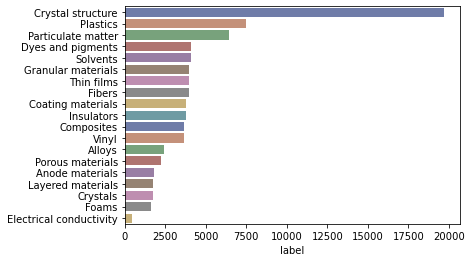

In [33]:
# visualize the number of labels after cleaning
count = clean_data.label.value_counts()
sns_bar(count, axes=None);

In [21]:
# https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
print('The word "{}" after stemming is "{}"'.format('operate', PorterStemmer().stem('operate')))
print('The word "{}" after stemming is "{}"'.format('operational', PorterStemmer().stem('operational')))

The word "operate" after stemming is "oper"
The word "operational" after stemming is "oper"


In [22]:
# define function to perform lemmatization using POS tagging
# lemmatization on each word will be performed according the individual's POS tagging
# if no POS tag returned, keep the original forms of the words
tagger = PerceptronTagger()
lemm = WordNetLemmatizer()
tag_dict = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'J': wordnet.ADJ, 'R': wordnet.ADV}
def get_lemmatized(token):  
    return [lemm.lemmatize(word, tag_dict.get(tagger.tag([word])[0][1][0].upper())) 
            if tag_dict.get(tagger.tag([word])[0][1][0].upper())!=None else word for word in token]

In [23]:
# perform lemmatization on the cleaned abstract
start = time.time()

clean_data['lemm_tokens'] = clean_data.tokens.apply(get_lemmatized)

print('The elapsed time is', (time.time() - start)/60)

The elapsed time is 20.765604877471922


In [24]:
# tokenize the lemmatized abstract
# save the cleaned training data to clean_train.csv
clean_data['lemm'] = clean_data.lemm_tokens.apply(lambda x: ' '.join(x))
train_output = clean_data[['clean', 'lemm', 'label']]
train_output.to_csv('./clean_train.csv', index=False)

## Test Data Preprocessing

In [25]:
# import the test data
test = pd.read_csv('./test_data.csv')
test.head()

,test_id,abstract,label
0,1,Edible air pollution was on the menu at the Id...,NaN
1,2,Improved moisture stability is desired in cell...,NaN
2,3,Mesoporous silica nanoparticles are used to fa...,NaN
3,4,We report on a simple and versatile method for...,NaN
4,5,The growth of suitable protein crystals is an ...,NaN


In [26]:
# perform the text preprocessing using the same approach for training data
test['clean'] = test.abstract.apply(get_clean) 
test['tokens'] = test.clean.apply(word_tokenize)
test['lemm'] = test.tokens.apply(get_lemmatized).apply(lambda x: ' '.join(x))

In [27]:
# check if there is any zero token
test[test.tokens.apply(len)==0]

,test_id,abstract,label,clean,tokens,lemm
812,813,1300,NaN,,[],
7332,7333,", ▪ , ▪ ...",NaN,,[],


In [28]:
# replace the data with zero token by their original abstract
test['clean'][test.index==812] = '1300'
test['lemm'][test.index==812] = '1300'

test['clean'][test.index==7332] = '...'
test['lemm'][test.index==7332] = '...'

<ipython-input-28-fcbc67438ebb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['clean'][test.index==812] = '1300'
<ipython-input-28-fcbc67438ebb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['lemm'][test.index==812] = '1300'
<ipython-input-28-fcbc67438ebb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['clean'][test.index==7332] = '...'
<ipython-input-28-fcbc67438ebb>:5: SettingWithCopyWarning: 
A value is trying

In [29]:
# save the cleaned test data to clean_test.csv
test_output = test[['test_id', 'clean', 'lemm']]
test_output.to_csv('./clean_test.csv', index=False)